### This data is from Feng's files

['transImg', 'x', 'y']


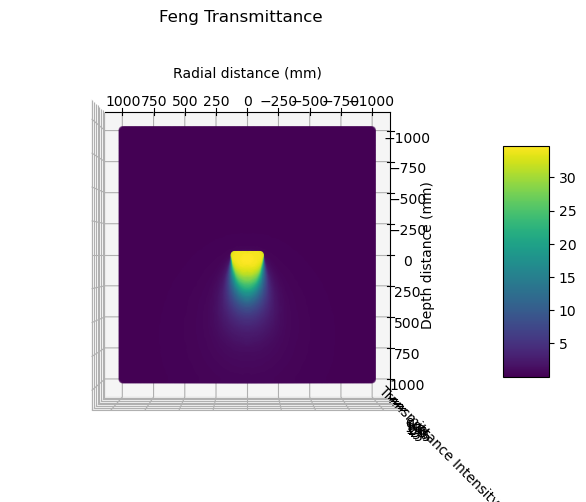

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load Transmittance Data using h5py
with h5py.File('TransmittanceData.mat', 'r') as f:
    print(list(f.keys()))  # Display dataset keys
    light_lateral_xy = np.array(f['x'])            
    light_depth = np.array(f['y'])
    transImg = np.array(f['transImg'])

# Filter the data where both x and y are between -1 and 1
valid_indices = (light_lateral_xy >= -1) & (light_lateral_xy <= 1) & (light_depth >= -1) & (light_depth <= 1)

# Apply the mask to filter the data
filtered_x = light_lateral_xy[valid_indices]
filtered_y = light_depth[valid_indices]
filtered_transImg = transImg[valid_indices]

filtered_x = filtered_x * 1000
filtered_y = filtered_y * 1000

# Set up the 3D plot
fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111, projection='3d')

# Plot the filtered data
ax1.scatter(filtered_x, filtered_y, filtered_transImg, c=filtered_transImg, cmap='viridis')

fig1.colorbar(ax1.scatter(filtered_x, filtered_y, filtered_transImg, c=filtered_transImg, cmap='viridis'), ax=ax1, shrink=0.5, aspect=5)

# Set plot title and labels
ax1.view_init(elev=90, azim=90)
ax1.set_title('Feng Transmittance')
ax1.set_xlabel('Radial distance (mm)')
ax1.set_ylabel('Depth distance (mm)')
ax1.set_zlabel('Transmittance Intensity')

plt.show()


# convert Feng's Data into the format used by the module

In [2]:
np.save('feng_intensity_data.npy', {'R': filtered_x, 'Z': filtered_y, 'Intensity': filtered_transImg})

## This is the data from the Monte Carlo sim that I ran in matlab

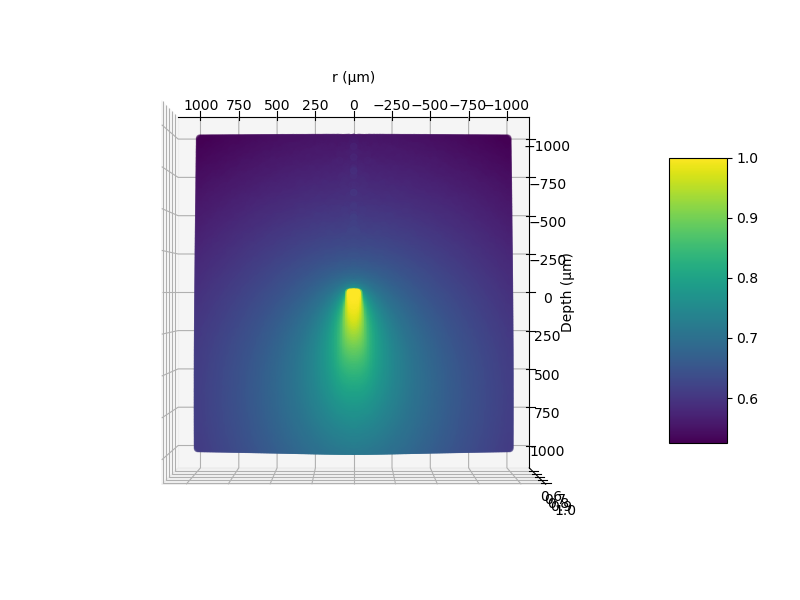

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

# Load the data from the .mat file
mat = scipy.io.loadmat('LightData_green.mat') # wrong light but want to keep 
mat = scipy.io.loadmat('LightData_blue.mat') 

def generate_light_plot(mat=None):
    # Extract the data arrays
    r = mat['r'].flatten()  # Radial distances (r)
    depth = mat['depth'].flatten()  # Depth (depth)
    plot_mat = mat['plot_mat']  # The matrix to plot

    # Convert r and depth from mm to µm
    r = r * 1000  # Convert radial distance to micrometers (µm)
    depth = depth * 1000  # Convert depth to micrometers (µm)

    # Create mirrored radial distance (r_mirrored)
    r_mirrored = np.concatenate([-r[::-1], r])  # Create a new range from -r to +r

    # Mirror the plot_mat matrix: reverse the columns of plot_mat and concatenate
    plot_mat_mirrored = np.concatenate([plot_mat[:, ::-1], plot_mat], axis=1)

    # Replace -inf values with np.nan
    plot_mat_mirrored[plot_mat_mirrored == -np.inf] = np.nan

    # Calculate the min and max ignoring NaN
    min_val = np.nanmin(plot_mat_mirrored)
    max_val = np.nanmax(plot_mat_mirrored)

    plot_mat_mirrored_normalized = (plot_mat_mirrored - min_val) / (max_val - min_val)

    # Create a meshgrid for the mirrored r and depth
    R, Depth = np.meshgrid(r_mirrored, depth)

    # Filter the data to only include points where r and depth are between -1 and 1 micrometers
    valid_indices = (R >= -1e3) & (R <= 1e3) & (Depth >= -1e3) & (Depth <= 1e3)

    # Apply the mask to the data
    R_valid = R[valid_indices]
    Depth_valid = Depth[valid_indices]
    plot_mat_valid = plot_mat_mirrored_normalized[valid_indices]

    # Create a new figure and axis
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Create the surface plot with filtered data
    ax.scatter(R_valid, Depth_valid, plot_mat_valid, c=plot_mat_valid, cmap='viridis')

    # Adjust the view and axis labels
    ax.view_init(elev=90, azim=90)  # Same view as in MATLAB (top view)
    ax.set_xlabel('r (µm)')  # Update to µm
    ax.set_ylabel('Depth (µm)')  # Update to µm

    # Add colorbar
    fig.colorbar(ax.scatter(R_valid, Depth_valid, plot_mat_valid, c=plot_mat_valid, cmap='viridis'), ax=ax, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

    return R_valid, Depth_valid, plot_mat_valid

# Call the function to generate the plot
rad_dist, depth_dist, intensity_dist = generate_light_plot(mat)


## convert this data into data usable for the module

In [4]:
np.save('blue_light_intensity_data.npy', {'R': rad_dist, 'Z': depth_dist, 'Intensity': intensity_dist})

## mapping the intensity data to the nodes in BMTK

In [5]:

nodes = load_nodes_from_config('../../Model-Parameters/simulation_config_baseline.json')
nodes = nodes['cortex']

def get_intensity(nodes,R,Depth,plot_mat,probe_position=[0,0,0]):
    """gets the light intensity for every node.

    Args:
        nodes (df): nodes from BMTK simulation
        R (2d np array): radidal distance from monte carlo sim
        Depth (2d np array): depth from monte carlo sim
        plot_mat (2d np array): light intensity with R and Depth from monte carlo 
        probe_position (tuple): where light comes out from. Defaults to [0,0,0]
    """

    distance_x = nodes['pos_x'].values - probe_position[0]
    distance_y = nodes['pos_y'].values - probe_position[1]
    distance_z = nodes['pos_z'].values - probe_position[2]

    radial_distance = np.sqrt(distance_x**2 + distance_y**2)

    r_indices = np.array([np.argmin(np.abs(R[0, :] - r)) for r in radial_distance])
    depth_indices = np.array([np.argmin(np.abs(Depth[:, 0] - z)) for z in distance_z])


    node_intensities = plot_mat[depth_indices, r_indices]

    return node_intensities

intensity = get_intensity(probe_position=[0,0,0],nodes=nodes,R=rad_dist,Depth=depth_dist,plot_mat=intensity_dist)

NameError: name 'load_nodes_from_config' is not defined

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(nodes["pos_x"], nodes["pos_y"], nodes["pos_z"], c=intensity,cmap='viridis')
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

# Label the color bar
cbar.set_label('Light Intensity')

# Show the plot
plt.show()

In [ ]:
probe_locations = pd.read_csv("../checkerboard_locations/probe_positions.csv")

for index, row in probe_locations.iterrows():
    pos = np.array([row['X'], row['Y'], row['Z']])
    intensity = get_intensity(probe_position=pos,nodes=nodes,R=rad_dist,Depth=depth_dist,plot_mat=intensity_dist)